In [151]:
import os
import pickle
import math
import numpy as np
from math import *
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import graphviz
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Part 1. Finding largest differences between word counts

In [176]:
def part1(seed = 1):
    np.random.seed(seed)
    fake_data = './data/clean_fake.txt'
    real_data = './data/clean_real.txt'
    fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
    rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)
    
    fake = build_LM(fX_train)
    real = build_LM(rX_train)
    
    word_diff = []
    for word in fake.keys():
        if word in real.keys():
            word_diff.append((word, int(fake[word]-real[word])))
        else:
            word_diff.append((word,(fake[word])))
    for word in real.keys():
        if word not in fake.keys():
            word_diff.append((word,-(real[word])))
    word_diff = sorted(word_diff, key = lambda x: float(x[1]))
    
    print 'Three keywords that maybe useful for identifying real news: ', [i[0] for i in word_diff[-3:]]
    print 'Three keywords that maybe useful for identifying fake news: ', [i[0] for i in word_diff[:3]]
    realWord = word_diff[-3:]
    fakeWord = word_diff[:3]
    for word in realWord:
        print 'The word ', word[0]
        print 'occurs in real news '+ str(real[word[0]])+ ' times'
        print 'occurs in fake news '+ str(fake[word[0]])+ ' times'
        print 'difference is: ' + str(abs(int(word[1])))
    for word in fakeWord:
        print 'The word ', word[0]
        print 'occurs in real news '+ str(real[word[0]])+ ' times'
        print 'occurs in fake news '+ str(fake[word[0]])+ ' times'
        print 'difference is: ' + str(abs(int(word[1])))
    
#     print realWord
#     print fakeWord
    

In [177]:
part1(seed = 1)

Three keywords that maybe useful for identifying real news:  ['a', 'hillary', 'the']
Three keywords that maybe useful for identifying fake news:  ['donald', 'trump', 'trumps']
The word  a
occurs in real news 65 times
occurs in fake news 116 times
difference is: 51
The word  hillary
occurs in real news 10 times
occurs in fake news 103 times
difference is: 93
The word  the
occurs in real news 108 times
occurs in fake news 245 times
difference is: 137
The word  donald
occurs in real news 563 times
occurs in fake news 161 times
difference is: 402
The word  trump
occurs in real news 1219 times
occurs in fake news 898 times
difference is: 321
The word  trumps
occurs in real news 154 times
occurs in fake news 3 times
difference is: 151


# Part 2. Naive Bayes Algorithm

Some helper functions

In [9]:
# Obtaining data from the source file
# Split dataset into training 70%, validation 15%, and testing 15%.
def get_datasets(file):
    
    # files = os.listdir(data_dir)
    # for file in file_list:
    X = []
    y = []
    
    if file.split('.')[0][-4:] == 'fake':
        y_l = 1     # Fake = 1, Real = 0
    else:
        y_l = 0
        
    file = open(file, 'r').read().split('\n')
    for line in file:
        X.append(line)
        y.append(y_l)
    # Splitting the sets
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.30, seed=1)
    (X_test, X_val, y_test, y_val) = train_test_split(X_test, y_test, test_size=0.50, seed=1)

    return X_train, y_train, X_test, y_test, X_val, y_val

def train_test_split(x,y,test_size=0,seed=411):
    np.random.seed(seed)
    x_test, x_train = x[:int(len(x)*test_size)], x[int(len(x)*test_size):]
    y_test, y_train = y[:int(len(y)*test_size)], y[int(len(y)*test_size):]
    return x_train, x_test, y_train, y_test

def save_data(data, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_data(name):
    with open(name + '.pickle', 'rb') as handle:
        saved_data = pickle.load(handle)
    return saved_data

def build_LM(dataset):
    '''
    Creating dictionary that has a word as key, then a value that is the count of the word
    '''
    LM = {}
    # Adding counts
    for sentence in dataset:
        sentence = sentence.split()
        once = [] # Keepping track of words in the sentence that has been added to the language model
        for word in sentence:
            if word not in once: 
                once.append(word)
                if word not in LM.keys():
                    LM[word] = 1
                else:  # Duplicated words are not added into the dictionary count
                    LM[word] += 1
            else:
                pass 
    return LM

def prob(sentence, LM, m, p, total):    
    '''
    Input: sentence: process sentence, string
    LM: Unigram model created by function build_LM
    m, p: parameters
    total: total number of sentences in the specific dataset(fake or real)
    '''
    sentence = sentence.split()
    log_mle = 0
    for w in sentence:
        if w not in LM.keys():
            n = m*p
            d = total + m
            log_prob = math.log(n/d)
        else:
            n = LM[w] + m*p
            d = total + m
            log_prob = math.log(n/d)
        log_mle += log_prob
    for w in LM.keys():
        if w not in sentence:   # We have already included the case when w in sentence
            n = LM[w] + m*p
            d = total + m
            log_prob = math.log(1-n/d)
        log_mle += log_prob
    prob = math.exp(log_mle)
    return prob

def accuracy(X_test, y_test, fake, real, f_n, r_n, m, p):
    '''
    inputs:
        fake: Language model built in build_LM
        real: Language model built in build_LM
        X_test, y_test: test/validation cases and label
    return:
        accuracy of the testing cases
    '''
    count = 0.0
    
    pf = float(f_n/(f_n+r_n))
    pr = float(1-pf)
    
    for i in range(len(X_test)-1):
        fake_prob = prob(X_test[i], fake, m, p, f_n)*pf
        real_prob = prob(X_test[i], real, m, p, r_n)*pr
        if fake_prob > real_prob:
            predict = 1
        else:
            predict = 0
        if predict == y_test[i]:
            count += 1
    return count/len(X_test)
  

In [10]:
def naive_bayes(fX_train, fy_train, X_val, y_val, X_test, y_test, m, p):
    # Building dictionaries that contains the Unigram informations, for each key 'word', the value is the count of word appearance
    fake = build_LM(fX_train)
    real = build_LM(rX_train)
 
    # Saving data
    # save_data(fake, 'fake')
    # save_data(real, 'real')
    # load data
    # fake = load_data('fake')
    # real = load_data('real')
    
    X_train = fX_train + rX_train
    y_train = fy_train + ry_train
    X_val = fX_val + rX_val
    y_val = fy_val + ry_val
    X_test = fX_test + rX_test
    y_test = fy_test + ry_test
    
    f_n = float(len(fX_train))
    r_n = float(len(rX_train))
    
    a_train = accuracy(X_train, y_train, fake, real, f_n, r_n, m, p)
    a_val = accuracy(X_val, y_val, fake, real,f_n, r_n, m, p)
    a_test = accuracy(X_test, y_test, fake, real,f_n, r_n, m, p)
    
    print 'p = ' + str(p)
    print 'm = ' + str(m)
    print('Accuracy on training set is '+ str(a_train))
    print('Accuracy on validation set is '+ str(a_val))
    print('Accuracy on test set is '+ str(a_test))
   
    return a_val

In [16]:
fake_data = '/Users/yingxue_wang/Documents/cdf/csc411/Project3/data/clean_fake.txt'
real_data = '/Users/yingxue_wang/Documents/cdf/csc411/Project3/data/clean_real.txt'
fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)

X_train = fX_train + rX_train
y_train = fy_train + ry_train
X_val = fX_val + rX_val
y_val = fy_val + ry_val
X_test = fX_test + rX_test
y_test = fy_test + ry_test

best_m = 50
best_p = 0.01

m_range = np.array([50, 75, 100, 150])
p_range = np.array([0.01, 0.005, 0.001, 0.0005])
Max = 0
Accuracy = np.zeros([m_range.size, p_range.size])

for i, m in enumerate(m_range):
        for j, p in enumerate(p_range):
            Accuracy[j,i] = naive_bayes(fX_train, fy_train, X_val, y_val, X_test, y_test, m, p)
            if Accuracy[j,i] > Max:
                CMax = Accuracy[j,i]
                best_m = m
                best_p = p
save_data(Accuracy, 'Accuracy')

# p = 0.005
# m = 100
# Accuracy on training set is 0.958060288336
# Accuracy on validation set is 0.875255623722
# Accuracy on test set is 0.873469387755


p = 0.01
m = 50
Accuracy on training set is 0.954565312363
Accuracy on validation set is 0.869120654397
Accuracy on test set is 0.875510204082
p = 0.005
m = 50
Accuracy on training set is 0.964613368283
Accuracy on validation set is 0.871165644172
Accuracy on test set is 0.873469387755
p = 0.001
m = 50
Accuracy on training set is 0.974224552206
Accuracy on validation set is 0.869120654397
Accuracy on test set is 0.869387755102
p = 0.0005
m = 50
Accuracy on training set is 0.975972040192
Accuracy on validation set is 0.862985685072
Accuracy on test set is 0.863265306122
p = 0.01
m = 75
Accuracy on training set is 0.948885976409
Accuracy on validation set is 0.862985685072
Accuracy on test set is 0.871428571429
p = 0.005
m = 75
Accuracy on training set is 0.961555264308
Accuracy on validation set is 0.869120654397
Accuracy on test set is 0.873469387755
p = 0.001
m = 75
Accuracy on training set is 0.971603320227
Accuracy on validation set is 0.871165644172
Accuracy on test set is 0.867346

[[0.86912065 0.87116564 0.86912065 0.86298569]
 [0.86298569 0.86912065 0.87116564 0.86707566]
 [0.86707566 0.87525562 0.87116564 0.86503067]
 [0.85480573 0.86912065 0.87321063 0.86912065]]


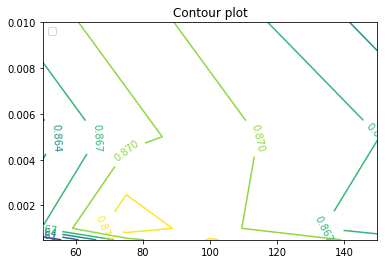

In [17]:
mz, pz = np.meshgrid(m_range, p_range)
val_accuracy = load_data('Accuracy')
print val_accuracy

CS = plt.contour(mz, pz, val_accuracy)
plt.clabel(CS)
plt.legend(loc='upper left')
plt.title('Contour plot')
plt.savefig("part2_figure2")
plt.show()

[[0.86912065 0.87116564 0.86912065 0.86298569]
 [0.86298569 0.86912065 0.87116564 0.86707566]
 [0.86707566 0.87525562 0.87116564 0.86503067]
 [0.85480573 0.86912065 0.87321063 0.86912065]]
[[0.86912065 0.86298569 0.86707566 0.85480573]
 [0.87116564 0.86912065 0.87525562 0.86912065]
 [0.86912065 0.87116564 0.87116564 0.87321063]
 [0.86298569 0.86707566 0.86503067 0.86912065]]


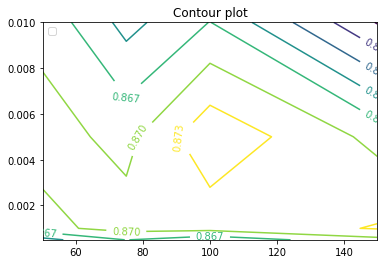

In [22]:
# after modification, this is the correct result
m_range = np.array([50, 75, 100, 150])
p_range = np.array([0.01, 0.005, 0.001, 0.0005])
Max = 0
acc = np.zeros([m_range.size, p_range.size])
val_accuracy = load_data('Accuracy')
for i in range(len(Accuracy)):
        for j in range(len(Accuracy[i])):
            acc[j,i] = Accuracy[i,j]
mz, pz = np.meshgrid(m_range, p_range)

print val_accuracy
print acc

CS = plt.contour(mz, pz, acc)
plt.clabel(CS)
plt.legend(loc='upper left')
plt.title('Contour plot')
plt.savefig("part2_figure2")
plt.show()


# Part 3. Picking Relevant/Non-relevant 

In [23]:
def prob_absence(word, LM, m, p, total):
    if word not in LM.keys(): #if it's not in our dictionary
        # print 'err: prob_absence(), word:', word, 'not in dictionary'
        n =  m * p
        d = total + m
        return float(n) / d
    else:
        n = total - LM[word] + m * p
        d = total + m
        return float(n) / d
#     if word not in LM.keys(): #if it's not in our dictionary
#         # print 'err: prob_absence(), word:', word,'not in dictionary'
#         n =  m * p
#         d = sum(LM.values()) + m
#         return float(n) / d
#     else:
#         n = sum(LM.values()) - LM[word] + m * p
#         d = sum(LM.values()) + m
#         return float(n) / d

In [32]:
def spam(f,r,m,p):
    '''
    :param f: fake news - array of strings
    :param r: real news - array of strings
    :param m: float some parameter
    :param p: float some parameter
    :return:
    '''
    n_f = len(f)
    n_r = len(r)
    fake = build_LM(f)
    real = build_LM(r)

    inp = ''
    while not inp == 'q':
        inp = raw_input('enter sentence:')
        pf = float(f_n/(f_n+r_n))
        pr = float(1-pf)

        fake_prob = prob(inp, fake, m, p, n_f) * pf
        real_prob = prob(inp, real, m, p, n_r) * pr

        print 'real:', real_prob
        print 'fake:', fake_prob

In [109]:
def topPresence(fX_train, rX_train, m, p):
    n_f = len(fX_train)
    n_r = len(rX_train)
    fake = build_LM(fX_train)
    real = build_LM(rX_train)
    
    pf = float(n_f/(n_f+n_r))
    pr = float(1-pf)
   
    results = []
    for word in set(fake.keys()+real.keys()):
        fake_prob = prob(word, fake, m, p, n_f) * pf
        real_prob = prob(word, real, m, p, n_r) * pr

        #normalize
        fake_prob = fake_prob / (fake_prob + real_prob)
        real_prob = 1 - fake_prob

        score = real_prob - fake_prob
        results.append((score, word))

    results = sorted(results, key = lambda x: float(x[0]))
    print 'most fake', [i[1] for i in results[:10]]
    print 'most real', [i[1] for i in results[-10:]]

    # remove stop word
    for i in results:
        if i[1] in ENGLISH_STOP_WORDS:
            results.remove(i)

    print 'stop: absent -> most fake', [i[1] for i in results[:10]]
    print 'stop: absent -> most real', [i[1] for i in results[-10:]]


In [34]:
def topAbsence(fX_train, rX_train, m, p):
    n_f = len(fX_train)
    n_r = len(rX_train)
    fake = build_LM(fX_train)
    real = build_LM(rX_train)

    pf = float(len(fake.keys())) / (len(fake.keys()) + len(real.keys()))
    pr = 1 - pf

    results = []
    for word in set(fake.keys() + real.keys()):
        fake_prob = prob_absence(word, fake, m, p, n_f) * pf
        real_prob = prob_absence(word, real, m, p, n_r) * pr

        #normalize
        fake_prob = fake_prob / (fake_prob + real_prob)
        real_prob = 1 - fake_prob

#         if word == 'hats':
#             print word,real_prob,fake_prob

        score = real_prob - fake_prob
        results.append((score, word))

    results = sorted(results, key = lambda x: float(x[0]))
    print 'absent -> most fake', [i[1] for i in results[:10]]
    print 'absent -> most real', [i[1] for i in results[-10:]]

    #remove stop word
    for i in results:
        if i[1] in ENGLISH_STOP_WORDS:
            results.remove(i)

    print 'stop: absent -> most fake', [i[1] for i in results[:10]]
    print 'stop: absent -> most real', [i[1] for i in results[-10:]]


In [91]:
# spam(fX_train,rX_train,300,0.01)

In [110]:
topPresence(fX_train,rX_train,75,0.005)

most fake ['obstruction', 'pardon', 'hats', 'personally', 'pide', 'extends', 'four', 'hath', 'protest', 'sleep']
most real ['rounding', 'pierson', 'compete', 'tensions', 'uneducated', 'lives', 'honchos', 'expands', 'defend', 'tanking']
stop: absent -> most fake ['obstruction', 'pardon', 'hats', 'personally', 'pide', 'extends', 'hath', 'protest', 'sleep', 'asian']
stop: absent -> most real ['rounding', 'pierson', 'compete', 'tensions', 'uneducated', 'lives', 'honchos', 'expands', 'defend', 'tanking']


In [36]:
topAbsence(fX_train,rX_train,75,0.005)

absent -> most fake ['hats', 'pide', 'hath', 'sleep', 'deri', 'saved', 'assembled', 'whose', 'vandal', 'edward']
absent -> most real ['cheque', 'exposure', 'stirred', 'imposes', 'ipswich', 'resolution', 'sliding', 'original', 'compete', 'expands']
stop: absent -> most fake ['hats', 'pide', 'hath', 'sleep', 'deri', 'saved', 'assembled', 'vandal', 'edward', 'lord']
stop: absent -> most real ['cheque', 'exposure', 'stirred', 'imposes', 'ipswich', 'resolution', 'sliding', 'original', 'compete', 'expands']


# Part 4: Logistic Regression Algorithm

Some helper functions

In [38]:
def get_mapped_matrix(X_train, word_list):
    c = 0.0
    X_matrix = np.ones((len(word_list),1))
    for data in X_train:
        c += 1
        if c%100 == 0:
            print c
        x = np.zeros((len(word_list),1))
        data = data.split()
        for i in range(len(word_list)):
            if word_list[i] in data:
                x[i] = 1
        X_matrix = np.hstack((X_matrix, x))
    X_matrix = X_matrix[:,1:] 
    return X_matrix


In [39]:
def sigmoid(y):
    # return 1/(1+np.exp(-(np.dot(theta.T, x))))
    return 1/(1+np.exp(-y))
  
# Without rgularization
# def f(x, y, theta):
#     '''
#     output dimenssion:(2287,)
#     '''
#     x = np.vstack((np.ones((1, len(x[0]))), x))
#     return y*np.log(sigmoid(np.dot(theta.T,x))) + (1-y)*np.log(1-sigmoid(np.dot(theta.T,x)))

# def df(x, y, theta):
#     # (4821,)
#     x = np.vstack((np.ones((1, len(x[0]))), x))
#     return np.sum((sigmoid(np.dot(theta.T,x))-y)*x, axis = 1)

# With Regularization
def f(x, y, theta, lamb=0):
    '''
    output dimenssion:(2287,)
    '''
    x = np.vstack((np.ones((1, len(x[0]))), x))
    return y*np.log(sigmoid(np.dot(theta.T,x))) + (1-y)*np.log(1-sigmoid(np.dot(theta.T,x))) + lamb*norm(theta)**2

def df(x, y, theta, lamb=0):
    # (4821,)
    x = np.vstack((np.ones((1, len(x[0]))), x))
    return np.sum((sigmoid(np.dot(theta.T,x))-y)*x, axis = 1) + 2*lamb*norm(theta)

def grad_descent(f, df, x, y, init_t, alpha, lamb=0):
    thetas = np.empty((x.shape[0]+1))
    EPS = 1e-5   
    prev_t = init_t-10*EPS
    t = init_t.copy()
    max_iter = 1500
    iter = 0
    while norm(t - prev_t) > EPS and iter < max_iter:  
        prev_t = t.copy()
        t -= alpha*df(x, y, t, lamb)
        iter += 1
        if iter % 50 == 0:
            thetas = np.vstack((thetas,t))
            print iter
    return thetas

In [40]:
def performace_test(X_test, y_test, thetas):
    performance = []
    
    X_test = np.vstack((np.ones((1, len(X_test[0]))), X_test))
    for theta in thetas:
        count = 0.0
        predict = sigmoid(np.dot(theta.T, X_test))
        for i in range(len(predict)):
            if predict[i] > 0.5:
                predict[i] = 1
            else:
                predict[i] = 0
            if predict[i] == y_test[i]:
                count += 1
        performance.append(count/X_test.shape[1])
    return performance

In [47]:
# Obtainning input matrix using the full training set
# Uncomment these when the first time running this code

# fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
# rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)

# X_train = fX_train + rX_train
# y_train = fy_train + ry_train
# X_val = fX_val + rX_val
# y_val = fy_val + ry_val
# X_test = fX_test + rX_test
# y_test = fy_test + ry_test

# LM = build_LM(X_train)
# word_list = list(LM.keys())     # len(word_list) = 4820
# X_train = get_mapped_matrix(X_train, word_list)
# X_val = get_mapped_matrix(X_val, word_list)
# X_test = get_mapped_matrix(X_test, word_list)
# save_data(X_train, 'X_train_logistic')
# save_data(X_val, 'X_val_logistic')
# save_data(X_test, 'X_test_logistic')

X_train = load_data('X_train_logistic')
X_val = load_data('X_val_logistic')
X_test = load_data('X_test_logistic')

# print X_train.shape    # (4820, 2287)

# Number of features: 4820 + 1 bias -> X:(4820, 2287)
# theta : (4821,)
# theta.T * x : 1 * 2287
# y = 1 * 2287
theta = np.zeros((X_train.shape[0]+1)) # 4821
y_train = np.reshape(y_train,(X_train.shape[1])).T     # (2287,)
alpha = 0.001

# Plot learning curves: Performance versus iterations
thetas = grad_descent(f, df, X_train, y_train, theta, alpha)
save_data(thetas, 'thetas_lamb_0')

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [ ]:
thetas = load_data('thetas_lamb_0')
performance_val = performace_test(X_val, y_val, thetas)
performance_train = performace_test(X_train, y_train, thetas)
performance_test = performace_test(X_test, y_test, thetas)

save_data(performance_val, 'performance_val')
save_data(performance_train, 'performance_train')
save_data(performance_test, 'performance_test')

print performance_val
print performance_train
print performance_test

Plot the Learning curve

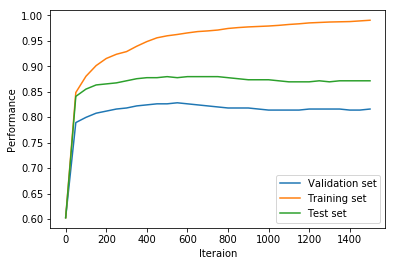

In [50]:
# Plot performance on validation set
# Plot performance on training set
performance_val = load_data('performance_val')
performance_train = load_data('performance_train')
performance_test_set = load_data('performance_test')
iteration = range(0,1501,50)
plt.plot(iteration, performance_val, iteration, performance_train, iteration, performance_test_set)
plt.legend(['Validation set', 'Training set','Test set'])
plt.xlabel('Iteraion')
plt.ylabel('Performance')
plt.savefig("performance_1500_0_001.png")
plt.show()

# Use alpha = 0.001, iteration = 1500
# Performance on validation set: Highest: 0.8282208588957055, overfit to 0.8159509202453987 at around 580 iterations
# Performance on test set goes up to 0.8714285714285714 at 155 iterations.
# [0.6032719836400818, 0.7893660531697342, 0.7995910020449898, 0.8077709611451943, 0.8118609406952966, 0.8159509202453987, 0.8179959100204499, 0.8220858895705522, 0.8241308793456033, 0.8261758691206544, 0.8261758691206544, 0.8282208588957055, 0.8261758691206544, 0.8241308793456033, 0.8220858895705522, 0.820040899795501, 0.8179959100204499, 0.8179959100204499, 0.8179959100204499, 0.8159509202453987, 0.8139059304703476, 0.8139059304703476, 0.8139059304703476, 0.8139059304703476, 0.8159509202453987, 0.8159509202453987, 0.8159509202453987, 0.8159509202453987, 0.8139059304703476, 0.8139059304703476, 0.8159509202453987]
# [0.6024464831804281, 0.8484054172127566, 0.8802970729576234, 0.9012669287898646, 0.9152468326780253, 0.9235474006116208, 0.928789864569681, 0.9392747924858017, 0.9484491044124072, 0.9558759283529926, 0.9598077763215378, 0.9624290083005679, 0.9654871122761031, 0.9681083442551333, 0.9694189602446484, 0.9711664482306684, 0.9742245522062036, 0.9759720401922237, 0.9772826561817387, 0.9781564001747488, 0.9790301441677588, 0.9803407601572739, 0.982088248143294, 0.9833988641328091, 0.9851463521188292, 0.9860200961118393, 0.9868938401048493, 0.9873307121013543, 0.9877675840978594, 0.9890782000873743, 0.9903888160768894]
# [0.6020408163265306, 0.8408163265306122, 0.8551020408163266, 0.863265306122449, 0.8653061224489796, 0.8673469387755102, 0.8714285714285714, 0.8755102040816326, 0.8775510204081632, 0.8775510204081632, 0.8795918367346939, 0.8775510204081632, 0.8795918367346939, 0.8795918367346939, 0.8795918367346939, 0.8795918367346939, 0.8775510204081632, 0.8755102040816326, 0.8734693877551021, 0.8734693877551021, 0.8734693877551021, 0.8714285714285714, 0.8693877551020408, 0.8693877551020408, 0.8693877551020408, 0.8714285714285714, 0.8693877551020408, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714]

Part 4b. Tuning Lambda

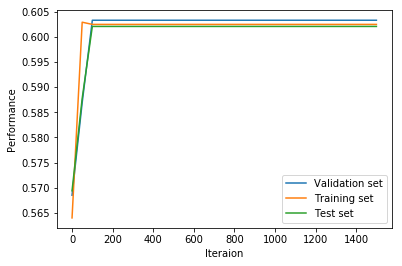

Lambda is now: 1
Final performance on validation set is: 0.60327198364
Final performance on test set is: 0.602040816327


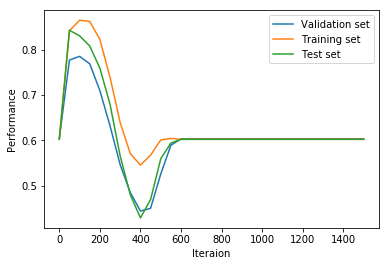

Lambda is now: 0.1
Final performance on validation set is: 0.60327198364
Final performance on test set is: 0.602040816327


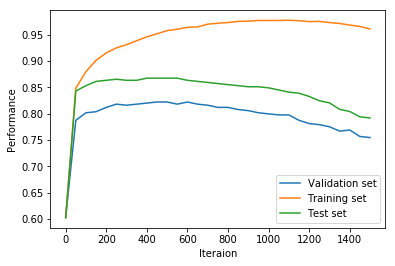

Lambda is now: 0.01
Final performance on validation set is: 0.754601226994
Final performance on test set is: 0.791836734694


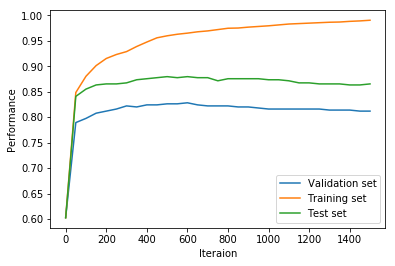

Lambda is now: 0.001
Final performance on validation set is: 0.811860940695
Final performance on test set is: 0.865306122449


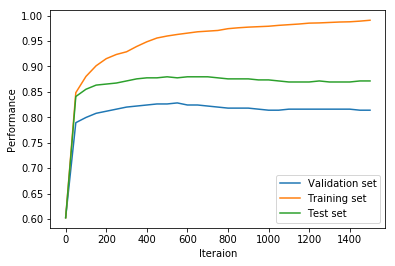

Lambda is now: 0.0001
Final performance on validation set is: 0.81390593047
Final performance on test set is: 0.871428571429


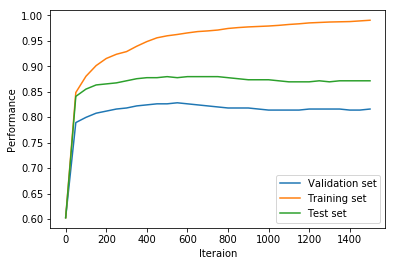

Lambda is now: 0
Final performance on validation set is: 0.815950920245
Final performance on test set is: 0.871428571429


In [64]:
theta = np.zeros((X_train.shape[0]+1)) # 4821
lamb_list = [1, 0.1, 0.01, 0.001, 0.0001, 0]
alpha = 0.001
for lamb in lamb_list:
#     # Obtain theta
#     thetas = grad_descent(f, df, X_train, y_train, theta, alpha, lamb)
#     save_data(thetas, 'thetas_%f'%lamb)
    
#     # Obtain performance on training and validation set
#     performance_train = performace_test(X_train, y_train, thetas)
#     performance_val = performace_test(X_val, y_val, thetas)
#     performance_test_set = performace_test(X_test, y_test, thetas)
#     save_data(performance_train, 'performance_train_%f'%lamb)
#     save_data(performance_val, 'performance_val_%f'%lamb)
#     save_data(performance_test_set, 'performance_test_%f'%lamb)

    performance_train = load_data('performance_train_%f'%lamb)
    performance_val = load_data('performance_val_%f'%lamb)
    performance_test_set = load_data('performance_test_%f'%lamb)
    iteration = range(0,1501,50)
    plt.plot(iteration, performance_val, iteration, performance_train, iteration, performance_test_set)
    plt.legend(['Validation set', 'Training set', 'Test set'])
    plt.xlabel('Iteraion')
    plt.ylabel('Performance')
    plt.savefig("performance_1500_%f.png"%lamb)
    plt.show()
    print 'Lambda is now: ' + str(lamb)
    print 'Final performance on validation set is: ' + str(performance_val[-1])
    print 'Final performance on test set is: ' + str(performance_test_set[-1])

Finding Top 10 positive thetas and Top 10 negative thetas with tuned alpha and lambda

In [72]:
# fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
# rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)

# X_train = fX_train + rX_train
# y_train = fy_train + ry_train
# X_val = fX_val + rX_val
# y_val = fy_val + ry_val
# X_test = fX_test + rX_test
# y_test = fy_test + ry_test

# LM = build_LM(X_train)
# word_list = list(LM.keys())     # len(word_list) = 4820
# X_train = get_mapped_matrix(X_train, word_list)
# X_val = get_mapped_matrix(X_val, word_list)
# X_test = get_mapped_matrix(X_test, word_list)
# save_data(X_train, 'X_train_logistic')
# save_data(X_val, 'X_val_logistic')
# save_data(X_test, 'X_test_logistic')

X_train = load_data('X_train_logistic')
X_val = load_data('X_val_logistic')
X_test = load_data('X_test_logistic')

lamb = 0
alpha = 0.001
thetas = grad_descent(f, df, X_train, y_train, theta, alpha, lamb)
dave_data(thetas, 'best_thetas')


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


# Part 5

There is no need for code

# Part 6

Part 6a. Displaying top 10 positive thetas and top 10 negative thetas

In [180]:
def top_10(thetas, word_list, remove_stop_words = False):
    best_theta = thetas[-1]
    theta_word = []
    if not remove_stop_words: # Do not remove stop words
        for i in range(len(word_list)):
            theta_word.append((best_theta[i], word_list[i]))
        results = sorted(theta_word, key = lambda x: float(x[0]))
        print 'Top 10 posotive thetas are: \n', [i[0] for i in results[-10:]]
        print 'The corresponded words are: \n', [i[1] for i in results[-10:]]
        print '\n'
        print 'Top 10 negative thetas are: \n', [i[0] for i in results[:10]]
        print 'The corresponded words are: \n', [i[1] for i in results[:10]]
    else:
        for i in range(len(word_list)):
            if word_list[i] not in ENGLISH_STOP_WORDS:
                theta_word.append((best_theta[i], word_list[i]))
        results = sorted(theta_word, key = lambda x: float(x[0]))
        print 'Top 10 positive thetas are: \n', [i[0] for i in results[-10:]]
        print 'The corresponded words are: \n', [i[1] for i in results[-10:]]
        print '\n'
        print 'Top 10 negative thetas are: \n', [i[0] for i in results[:10]]
        print 'The corresponded words are: \n', [i[1] for i in results[:10]]
        

In [181]:
def part6a():
    thetas = load_data('thetas_lamb_0')

    fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
    rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)
    X_train = fX_train + rX_train
    LM = build_LM(X_train)
    word_list = list(LM.keys())     # len(word_list) = 4820
    top_10(thetas, word_list)

In [182]:
part6a()

Top 10 posotive thetas are: 
[1.8809302150080827, 1.9934145943171715, 2.0401576548350424, 2.1494908376159287, 2.15205676191225, 2.30275064042435, 2.478758429828731, 2.5548512378412696, 2.743401424909237, 2.9219077934300066]
The corresponded words are: 
['guns', 'may', 'founder', 'treasury', 'photo', 'sea', 'waters', 'each', 'ridiculous', 'dismissed']


Top 10 negative thetas are: 
[-3.5114534363844396, -2.561600927102143, -2.1988569260688666, -2.145612789788321, -2.086812729418098, -2.0305162419677396, -1.8805042581279057, -1.799684811327131, -1.7788772697931388, -1.6851121878678401]
The corresponded words are: 
['candidates', 'stalking', 'nevada', 'patrol', 'mujer', 'completely', 'obstruction', 'entire', 'fearing', 'depressing']


Part 3b. ignore all stop words

In [141]:
def part6b():
    thetas = load_data('thetas_lamb_0')

    fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
    rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)
    X_train = fX_train + rX_train
    LM = build_LM(X_train)
    word_list = list(LM.keys())     # len(word_list) = 4820
    top_10(thetas, word_list, remove_stop_words = True)

In [142]:
part6b()

Top 10 posotive thetas are: 
[1.80710464960545, 1.8472006428405927, 1.8809302150080827, 2.0401576548350424, 2.1494908376159287, 2.15205676191225, 2.30275064042435, 2.478758429828731, 2.743401424909237, 2.9219077934300066]
The corresponded words are: 
['perspectives', 'behold', 'guns', 'founder', 'treasury', 'photo', 'sea', 'waters', 'ridiculous', 'dismissed']


Top 10 negative thetas are: 
[-3.5114534363844396, -2.561600927102143, -2.1988569260688666, -2.145612789788321, -2.086812729418098, -2.0305162419677396, -1.8805042581279057, -1.799684811327131, -1.7788772697931388, -1.6851121878678401]
The corresponded words are: 
['candidates', 'stalking', 'nevada', 'patrol', 'mujer', 'completely', 'obstruction', 'entire', 'fearing', 'depressing']


# Part 7. Decision Tree

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [67]:
def part7a(x_train, y_train, x_valid, y_valid):
    xt, yt = list(x_train), list(y_train) #make copy
    xv, yv = list(x_valid), list(y_valid)

    #create dictionary
    d = build_LM(xt+xv)
    dictionary = d.keys()
 
    # preprocess data
    for i in range(len(xt)):
        vector = [0]*len(dictionary)
        for word in xt[i].split():
            vector[dictionary.index(word)] = 1
        xt[i] = vector

    for i in range(len(xv)):
        vector = [0]*len(dictionary)
        for word in xv[i].split():
            vector[dictionary.index(word)] = 1
        xv[i] = vector

    #train tree
    val_scores = []
    test_scores = []
    vals = range(1,30,3)
    for depth in vals:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        clf.fit(xt,yt)

        #validate
        val_scores.append(test_tree(clf, xt, yt))
        test_scores.append(test_tree(clf, xv, yv))

    print vals
    print test_scores
    print val_scores

    #graph
    plt.plot(vals,test_scores,vals,val_scores)
    plt.legend(["validation set", "test set"])
    plt.title("Performance of decision tree for various max depths")
    plt.ylabel("performance (%)")
    plt.xlabel("max depth")
    plt.show()
    

In [108]:
fX_train, fy_train, fX_test, fy_test, fX_val, fy_val = get_datasets(fake_data)
rX_train, ry_train, rX_test, ry_test, rX_val, ry_val = get_datasets(real_data)

X_train = fX_train + rX_train
y_train = fy_train + ry_train
X_val = fX_val + rX_val
y_val = fy_val + ry_val
X_test = fX_test + rX_test
y_test = fy_test + ry_test

# LM = build_LM(X_train)
# word_list = list(LM.keys())     # len(word_list) = 4820
# X_train = get_mapped_matrix(X_train, word_list)
# X_val = get_mapped_matrix(X_val, word_list)
# X_test = get_mapped_matrix(X_test, word_list)
# save_data(X_train, 'X_train_logistic')
# save_data(X_val, 'X_val_logistic')
# save_data(X_test, 'X_test_logistic')

X_train = load_data('X_train_logistic')
X_val = load_data('X_val_logistic')
X_test = load_data('X_test_logistic')

part7a(X_train, y_train, X_val, y_val)

AttributeError: 'numpy.ndarray' object has no attribute 'split'